# model

> Defines data and processing structures.

In [ ]:
#| default_exp model

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path
from datetime import datetime, timezone
from matplotlib.pyplot import show
import ipywidgets as w
import multiprocessing
import gc

In [ ]:
#| export
from typing import Callable
from matplotlib.figure import Figure
from matplotlib.axes._axes import Axes 

In [ ]:
#| export
from neuralactivitycubic.datamodels import Config
from neuralactivitycubic.processing import AnalysisJob
from neuralactivitycubic.input import RecordingLoaderFactory, ROILoaderFactory, RecordingLoader, ROILoader, get_filepaths_with_supported_extension_in_dirpath, FocusAreaPathRestrictions

In [ ]:
#| export
class Logger:
    def __init__(self):
        self.logs = []

    def add_new_log(self, message: str) -> None:
        time_prefix_in_utc = datetime.now(timezone.utc).strftime('%d-%m-%y %H:%M:%S.%f')
        self.logs.append(f'{time_prefix_in_utc} (UTC): {message}')
        print(f'{time_prefix_in_utc} (UTC): {message}')

    def get_logs(self) -> list[str]:
        return self.logs

    def clear_logs(self) -> None:
        self.logs = []

    def save_current_logs(self, save_dir: Path) -> None:
        filepath = save_dir.joinpath('logs.txt')
        with open(filepath , 'w+') as logs_file:
            for log_message in self.logs:
                logs_file.write(f'{log_message}\n')
        print(f'Logs saved to {filepath}')


In [ ]:
#| export
class Model:

    def __init__(self, config: Config | str) -> None:
        self.num_processes = multiprocessing.cpu_count()
        self.analysis_job_queue = []
        self.result_directories = []
        self.logs = Logger()
        if isinstance(config, str):
            config = Config(data_source_path=config)
        self.config = config
        self.nwb_metadata = None
        self.gui_enabled = False
        self.callback_view_update_infos = None
        self.callback_view_show_output_screen = None
        self.view_output = None
        self.pixel_conversion = None


    def setup_connection_to_update_infos_in_view(self, update_infos: Callable) -> None:
        self.callback_view_update_infos = update_infos
        self.gui_enabled = True


    def setup_connection_to_display_results(self, show_output_screen: Callable, output: w.Output, pixel_conversion: float) -> None:
        self.callback_view_show_output_screen = show_output_screen
        self.view_output = output
        self.pixel_conversion = pixel_conversion
        self.gui_enabled = True


    def add_info_to_logs(self, message: str, display_in_gui: bool = False, progress_in_percent: float | None = None) -> None:
        self.logs.add_new_log(message)
        if (display_in_gui == True) and (self.gui_enabled == True): 
            self.callback_view_update_infos(message, progress_in_percent)


    def _ensure_data_from_previous_jobs_was_removed(self) -> None:
        self.add_info_to_logs('Loading of new source data. All previously created jobs & logs will be deleted.', True)
        self.analysis_job_queue = []
        self.logs.clear_logs()

    @staticmethod
    def _get_all_subdir_paths_with_rec_file(top_level_dir_path: Path) -> list[Path]:
        rec_loader_factory = RecordingLoaderFactory()
        supported_extensions_for_recordings = rec_loader_factory.all_supported_extensions
        all_subdir_paths_that_contain_a_supported_recording_file = []
        for elem in top_level_dir_path.iterdir():
            if not elem.name.startswith('.'):
                if elem.is_dir():
                    supported_recording_filepaths = [elem_2 for elem_2 in elem.iterdir() if elem_2.suffix in supported_extensions_for_recordings]
                    if len(supported_recording_filepaths) > 0:
                        all_subdir_paths_that_contain_a_supported_recording_file.append(elem)
        return all_subdir_paths_that_contain_a_supported_recording_file


    def _create_analysis_jobs_for_single_rec(self, recording_path: Path = None, result_path: Path = None) -> None:
        if recording_path is None:
            if self.config.recording_filepath:
                recording_path = self.config.recording_filepath
            else:
                recording_path = self.config.data_source_path
        self.add_info_to_logs(f'Starting with Job creation(s) for {str(recording_path)}', True)
        recording_loader = self._get_recording_loader(recording_path)


        if self.config.roi_filepath:
            roi_filepath = self.config.roi_filepath
        else:
            roi_filepath = recording_loader.filepath.parent

        if self.config.roi_mode == 'file':
            roi_loaders = self._get_all_roi_loaders(roi_filepath)
        else:
            roi_loaders = None

        if self.config.focus_area_filepath:
            focus_area_filepath = self.config.focus_area_filepath
        else:
            focus_area_filepath = recording_loader.filepath.parent

        if result_path is None:
            if self.config.results_filepath:
                result_path = self.config.results_filepath
            else:
                result_path = recording_loader.filepath.parent

        if self.config.focus_area_enabled:
            focus_area_dir_path = self._get_focus_area_dir_path(focus_area_filepath)
            if focus_area_dir_path is None:
                analysis_job = self._create_single_analysis_job(recording_loader, roi_loaders, result_filepath=result_path)
                self.analysis_job_queue.append(analysis_job)
                self.add_info_to_logs(f'Successfully created a single job for {focus_area_filepath} at queue position: #{len(self.analysis_job_queue)}.', True)
            else:
                all_focus_area_loaders = self._get_all_roi_loaders(focus_area_dir_path)
                assert len(all_focus_area_loaders) > 0, f'Focus Area analysis enabled, but no focus area ROIs could be found. Please revisit your source data and retry!'
                for idx, focus_area_loader in enumerate(all_focus_area_loaders):
                    if result_path is None:
                        if self.config.results_filepath:
                            result_path = self.config.results_filepath / focus_area_loader.filepath.stem
                    analysis_job_with_focus_area = self._create_single_analysis_job(recording_loader, roi_loaders, focus_area_loader, result_filepath=result_path)
                    self.analysis_job_queue.append(analysis_job_with_focus_area)
                    job_creation_message = (f'Successfully created {idx + 1} out of {len(all_focus_area_loaders)} job(s) for {recording_path} '
                                            f'at queue position: #{len(self.analysis_job_queue)}.')
                    self.add_info_to_logs(job_creation_message, True)
        else:
            analysis_job = self._create_single_analysis_job(recording_loader, roi_loaders, result_filepath=result_path)
            self.analysis_job_queue.append(analysis_job)
            self.add_info_to_logs(f'Successfully created a single job for {recording_path} at queue position: #{len(self.analysis_job_queue)}.', True)
        self.add_info_to_logs(f'Finished Job creation(s) for {recording_path}!', True)


    def _get_recording_loader(self, source_path: Path) -> RecordingLoader:
        rec_loader_factory = RecordingLoaderFactory()
        if source_path.is_dir():
            self.add_info_to_logs(f'Looking for a valid recording file in {source_path}...', True)
            valid_filepaths = get_filepaths_with_supported_extension_in_dirpath(source_path, rec_loader_factory.all_supported_extensions, 1)
            if len(valid_filepaths) == 0:
                self.add_info_to_logs(f'Could not find any recording files of supported type at {source_path}!', True)
            elif len(valid_filepaths) >  1:
                filepath = valid_filepaths[0]
                too_many_files_message = (f'Found more than a single recording file of supported type at {source_path}, i.e.: {valid_filepaths}. '
                                          f'However, only a single file was expected. NA3 continues with {filepath} and will ignore the other files.')
                self.add_info_to_logs(too_many_files_message, True)
            else:
                filepath = valid_filepaths[0]
                self.add_info_to_logs(f'Found recording file of supported type at: {filepath}.', True)
        else:
            filepath = source_path
            self.add_info_to_logs(f'Found recording file of supported type at: {filepath}.', True)
        recording_loader = rec_loader_factory.get_loader(filepath)
        return recording_loader


    @staticmethod
    def _get_all_roi_loaders(data_source_path: Path) -> list[ROILoader]:
        assert data_source_path.is_dir(), f'You must provide a directory as source data when using ROI mode or enabling Focus Areas. Please revisit your input data and retry.'
        roi_loader_factory = ROILoaderFactory()
        all_filepaths_with_supported_filetype_extensions = get_filepaths_with_supported_extension_in_dirpath(data_source_path, roi_loader_factory.all_supported_extensions)
        all_roi_loaders = [roi_loader_factory.get_loader(roi_filepath) for roi_filepath in all_filepaths_with_supported_filetype_extensions]
        return all_roi_loaders


    def _get_focus_area_dir_path(self, source_path: Path) -> Path:
        focus_area_path_restrictions = FocusAreaPathRestrictions()
        supported_dir_names = focus_area_path_restrictions.supported_dir_names
        if source_path.is_dir():
            source_dir_path = source_path
        else:
            source_dir_path = source_path.parent
        dirs_with_valid_name = [elem for elem in source_dir_path.iterdir() if (elem.name in supported_dir_names) & (elem.is_dir() == True)]
        if len(dirs_with_valid_name) == 0:
            no_dir_found_message = (f'You enabled Focus Area but a correspondingly named directory could not be found in {source_dir_path}. '
                                    f'Please use one of the following for the name of the directory that contains the Focus Area ROIs: {supported_dir_names}. '
                                    'In absence of such a directory, analysis is continued without using the Focus Area mode for this data.')
            self.add_info_to_logs(no_dir_found_message, True)
            focus_area_dir_path = None
        elif len(dirs_with_valid_name) > 1:
            too_many_dirs = (f'More than a single Focus Area directory was found in the following parent directory: {source_dir_path}, i.e.: '
                             f'{dirs_with_valid_name}. However, only the use of a single one that contains all your Focus Area ROIS is '
                             f'currently supported. {dirs_with_valid_name[0]} will be used for this analysis, while the other(s): {dirs_with_valid_name[1:]} '
                             'will be ignored to continue processing.')
            self.add_info_to_logs(too_many_dirs, True)
            focus_area_dir_path = dirs_with_valid_name[0]
        else:
            focus_area_dir_path = dirs_with_valid_name[0]
        return focus_area_dir_path


    def _create_single_analysis_job(self, recording_loader: RecordingLoader, roi_loaders: list[ROILoader] | None, focus_area_loader: ROILoader = None, result_filepath: Path = None) -> AnalysisJob:
        data_loaders = {'recording': recording_loader}
        if roi_loaders is not None:
            data_loaders['rois'] = roi_loaders
        if focus_area_loader is not None:
            data_loaders['focus_area'] = focus_area_loader
        return AnalysisJob(self.num_processes, data_loaders, result_filepath)


    def _display_configs(self) -> None:
        self.add_info_to_logs('Configurations for Analysis Settings and Result Creation validated successfully.', True)
        self.add_info_to_logs(f'Analysis Settings are:')
        for line in self.config.display_all_attributes():
            self.add_info_to_logs(line)

    def _save_user_settings_as_json(self, analysis_job: AnalysisJob) -> None:
        filepath = analysis_job.results_dir_path.joinpath('user_settings.json')
        self.config.recording_filepath = analysis_job.recording.filepath
        if analysis_job.focus_area_enabled:
            self.config.focus_area_filepath = analysis_job.focus_area.filepath
        else:
            self.config.focus_area_filepath = None
        if analysis_job.rois_source == 'file':
            self.config.roi_filepath = [roi.filepath for roi in analysis_job.all_rois]
        with open(filepath, 'w+') as user_settings_json:
            user_settings_json.write(self.config.to_json())


    def create_analysis_jobs(self) -> None:
        self._ensure_data_from_previous_jobs_was_removed()
        self.add_info_to_logs('Basic configurations for data import validated. Starting creation of analysis job(s)...', True)
        if self.config.batch_mode:
            all_subdir_paths_with_rec_file = self._get_all_subdir_paths_with_rec_file(self.config.data_source_path)
            all_subdir_paths_with_rec_file.sort()
            for idx, subdir_path in enumerate(all_subdir_paths_with_rec_file):
                if self.config.results_filepath:
                    result_path = self.config.results_filepath / subdir_path.name
                else:
                    result_path = subdir_path
                self._create_analysis_jobs_for_single_rec(subdir_path, result_path)
        else:
            self._create_analysis_jobs_for_single_rec()
        self.add_info_to_logs('All job creation(s) completed.', True, 100.0)

    def run_analysis(self) -> None:
        self._display_configs()
        self.add_info_to_logs('Starting analysis...', True)
        for job_idx in range(len(self.analysis_job_queue)):
            analysis_job = self.analysis_job_queue.pop(0)
            self.add_info_to_logs(f'Starting to process analysis job with index #{job_idx}.')
            analysis_job.run_analysis(self.config)
            self.add_info_to_logs(f'Analysis successfully completed. Continue with creation of results.. ')
            analysis_job.create_results(self.config, self.nwb_metadata)
            self.add_info_to_logs(f'Results successfully created at: {analysis_job.results_dir_path}')
            if self.gui_enabled:
                self.callback_view_show_output_screen()
                with self.view_output:
                    activity_overview_fig = analysis_job.activity_overview_plot[0]
                    activity_overview_fig.set_figheight(400 * self.pixel_conversion)
                    activity_overview_fig.tight_layout()
                    show(activity_overview_fig)
            self._save_user_settings_as_json(analysis_job)
            self.result_directories.append(analysis_job.results_dir_path)
            self.add_info_to_logs('Updating all log files to contain all logs as final step. All valid logs files will end with this message.')
            self.logs.save_current_logs(analysis_job.results_dir_path)
        else:
            gc.collect()


    def preview_window_size(self, grid_size) -> tuple[Figure, Axes]:
        job_for_preview = self.analysis_job_queue[0]
        preview_fig, preview_ax = job_for_preview.preview_window_size(grid_size)
        return preview_fig, preview_ax

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

Setup for testing:

In [ ]:
from shutil import rmtree
import os
from re import compile

import pandas as pd
from pandas.testing import assert_frame_equal

from neuralactivitycubic.view import WidgetsInterface

test00_filepath = Path('../test_data/00')
test01_filepath = Path('../test_data/01')
parent_test_filepath = Path('../test_data')
example_results_dir = Path('../test_data/00/example_test_results_for_spiking_neuron')
results_filepath = Path('../test_data/00/results_directory')
# we have to split results by own directories due to concurrency issues
results_case01_filepath = Path('../test_data/results/case_01/')
results_case02_filepath = Path('../test_data/results/case_02/')
results_case03_filepath = Path('../test_data/results/case_03/')
results_case04_filepath = Path('../test_data/results/case_04/')
results_case05_filepath = Path('../test_data/results/case_05/')
results_case06_filepath = Path('../test_data/results/case_06/')

def test_correct_model_run():
    correct_config = WidgetsInterface().export_user_settings()
    correct_config.data_source_path = test00_filepath / 'spiking_neuron.avi'
    correct_config.save_single_trace_results = True
    model = Model(correct_config)
    model.create_analysis_jobs()
    model.run_analysis()
    return model.result_directories

def test_correct_model_run_with_custom_results_dir():
    correct_config = WidgetsInterface().export_user_settings()
    correct_config.data_source_path = test00_filepath / 'spiking_neuron.avi'
    correct_config.results_filepath = results_filepath
    model = Model(correct_config)
    model.create_analysis_jobs()
    model.run_analysis()
    return correct_config.results_filepath

# tests with different modes of running analysis

def test_run_grid_focus_mode():
    """
    Test run_analysis function with focus area enabled.
    """
    grid_focus_mode_config = WidgetsInterface().export_user_settings()
    grid_focus_mode_config.data_source_path = test01_filepath
    grid_focus_mode_config.focus_area_enabled = True
    grid_focus_mode_config.results_filepath = results_case01_filepath
    model = Model(grid_focus_mode_config)
    model.create_analysis_jobs()
    model.run_analysis()

    return grid_focus_mode_config.results_filepath

def test_run_file_focus_mode():
    """
    Test run_analysis function with focus area enabled.
    """
    file_focus_mode_config = WidgetsInterface().export_user_settings()
    file_focus_mode_config.data_source_path = test01_filepath
    file_focus_mode_config.focus_area_enabled = True
    file_focus_mode_config.roi_mode = 'file'
    file_focus_mode_config.results_filepath = results_case01_filepath
    model = Model(file_focus_mode_config)
    model.create_analysis_jobs()
    model.run_analysis()

    return file_focus_mode_config.results_filepath

def test_run_grid_batch_mode():
    """
    Test run_analysis function with batch mode enabled.
    """
    grid_batch_mode_config = WidgetsInterface().export_user_settings()
    grid_batch_mode_config.data_source_path = parent_test_filepath
    grid_batch_mode_config.batch_mode = True
    grid_batch_mode_config.results_filepath = results_case02_filepath
    model = Model(grid_batch_mode_config)
    model.create_analysis_jobs()
    model.run_analysis()

    return grid_batch_mode_config.results_filepath

def test_run_file_batch_mode():
    """
    Test run_analysis function with batch mode enabled.
    """
    file_batch_mode_config = WidgetsInterface().export_user_settings()
    file_batch_mode_config.data_source_path = parent_test_filepath
    file_batch_mode_config.batch_mode = True
    file_batch_mode_config.roi_mode = 'file'
    file_batch_mode_config.results_filepath = results_case02_filepath
    model = Model(file_batch_mode_config)
    model.create_analysis_jobs()
    model.run_analysis()

    return file_batch_mode_config.results_filepath

def test_run_grid_focus_batch_mode():
    """
    Test run_analysis function with focus and batch mode enabled.
    """
    grid_focus_batch_mode_config = WidgetsInterface().export_user_settings()
    grid_focus_batch_mode_config.data_source_path = parent_test_filepath
    grid_focus_batch_mode_config.batch_mode = True
    grid_focus_batch_mode_config.focus_area_enabled = True
    grid_focus_batch_mode_config.results_filepath = results_case03_filepath
    model = Model(grid_focus_batch_mode_config)
    model.create_analysis_jobs()
    model.run_analysis()

    return grid_focus_batch_mode_config.results_filepath

def test_run_file_focus_batch_mode():
    """
    Test run_analysis function with focus and batch mode enabled.
    """
    file_focus_batch_mode_config = WidgetsInterface().export_user_settings()
    file_focus_batch_mode_config.data_source_path = parent_test_filepath
    file_focus_batch_mode_config.batch_mode = True
    file_focus_batch_mode_config.focus_area_enabled = True
    file_focus_batch_mode_config.roi_mode = 'file'
    file_focus_batch_mode_config.results_filepath = results_case03_filepath
    model = Model(file_focus_batch_mode_config)
    model.create_analysis_jobs()
    model.run_analysis()

    return file_focus_batch_mode_config.results_filepath


In [ ]:
def _test_csv_files(relative_filepath_to_csv: str, results_dir: Path) -> bool:
    filepath = results_dir / relative_filepath_to_csv
    # confirm results have been created:
    if not filepath.is_file():
        return False
    # confirm computational consistency of results, while allowing minor numerical tolerance
    df_test = pd.read_csv(filepath)
    df_validation = pd.read_csv(example_results_dir / relative_filepath_to_csv)
    if assert_frame_equal(df_test, df_validation) is not None:
        return False
    else:
        return True

def test_all_peak_results(results_dir):
    return _test_csv_files('all_peak_results.csv', results_dir)

def test_amplitude_and_df_over_f_results(results_dir):
    return _test_csv_files('Amplitude_and_dF_over_F_results.csv', results_dir)

def test_auc_results(results_dir):
    return _test_csv_files('AUC_results.csv', results_dir)

def test_variance_area_results(results_dir):
    return _test_csv_files('Variance_area_results.csv', results_dir)

def test_representative_single_trace_results(results_dir):
    return _test_csv_files('single_traces/data_of_ROI_7-10.csv', results_dir)

def test_activity_overview_png(results_dir):
    filepath = results_dir / 'activity_overview.png'
    return filepath.is_file()

def test_roi_label_ids_overview_png(results_dir):
    filepath = results_dir / 'ROI_label_IDs_overview.png'
    return filepath.is_file()

def test_individual_traces_with_identified_events_pdf(results_dir):
    filepath = results_dir / 'Individual_traces_with_identified_events.pdf'
    return filepath.is_file()

def test_logs_txt(results_dir):
    filepath = results_dir / 'logs.txt'
    return filepath.is_file()

def test_user_settings_json(results_dir):
    filepath = results_dir / 'user_settings.json'
    return filepath.is_file()

def test_nwb_export(results_dir):
    filepath = results_dir / 'autogenerated_nwb_file.nwb'

def test_all_correct_files_created(results_dir: Path, test_csv: bool = True, single_trace: bool = False) -> bool:
    """
    Check if all expected files have been created in the results directory.
    """
    # confirm all csv files have been created and are correct:
    if test_csv:
        assert test_all_peak_results(results_dir), 'There is an issue with the "all_peak_results.csv" file!'
        assert test_amplitude_and_df_over_f_results(results_dir)
        assert test_auc_results(results_dir)
        assert test_variance_area_results(results_dir)
        if single_trace:
            assert test_representative_single_trace_results(results_dir)

    # confirm all other result files have been created:
    assert test_activity_overview_png(results_dir)
    assert test_roi_label_ids_overview_png(results_dir)
    assert test_logs_txt(results_dir)
    assert test_user_settings_json(results_dir)
    if single_trace:
        assert test_individual_traces_with_identified_events_pdf(results_dir)

    return True


def find_directories_after_test(base_path):
    """
    Find directories after test with timestamps.
    """
    pattern = compile(r'\d{4}_\d{2}_\d{2}_\d{2}-\d{2}-\d{2}_.+')

    matching_dirs = [
        str(base_path) + d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d)) and pattern.fullmatch(d)
    ]

    return matching_dirs

def delete_directories_after_test(paths_list):
    """
    Delete directories after test.
    """
    for res_dir in find_directories_after_test(paths_list):
        rmtree(res_dir)

Run tests:

24-07-25 09:40:52.947025 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:40:52.947109 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:40:52.947138 (UTC): Starting with Job creation(s) for ../test_data/00/spiking_neuron.avi
24-07-25 09:40:52.947529 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
24-07-25 09:40:52.947671 (UTC): Successfully created a single job for ../test_data/00/spiking_neuron.avi at queue position: #1.
24-07-25 09:40:52.947688 (UTC): Finished Job creation(s) for ../test_data/00/spiking_neuron.avi!
24-07-25 09:40:52.947699 (UTC): All job creation(s) completed.
24-07-25 09:40:52.947712 (UTC): Configurations for Analysis Settings and Result Creation validated successfully.
24-07-25 09:40:52.947719 (UTC): Analysis Settings are:
24-07-25 09:40:52.947816 (UTC): batch_mode: False
24-07-25 09:40:52.947827 (UTC): baseline_estimatio

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:56.987812 (UTC): Results successfully created at: ../test_data/00/2025_07_24_11-40-52_results_for_spiking_neuron
24-07-25 09:40:56.988272 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/00/2025_07_24_11-40-52_results_for_spiking_neuron/logs.txt


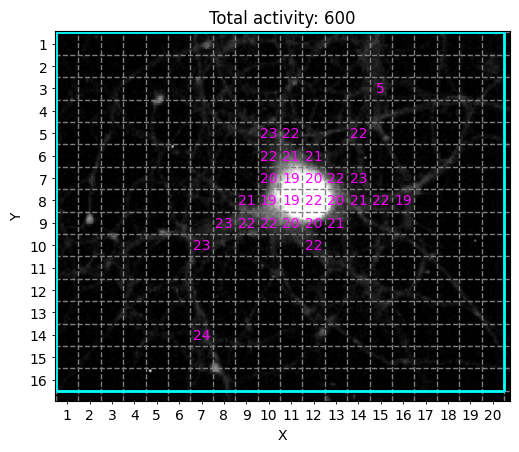

In [ ]:
# confirm that model can be executed:
result_directories = test_correct_model_run()

for directory in result_directories:
    assert directory.exists()
    assert test_all_correct_files_created(directory)
    # cleanup
    rmtree(directory)

24-07-25 09:39:29.228385 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:39:29.228441 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:39:29.228466 (UTC): Starting with Job creation(s) for ../test_data/00/spiking_neuron.avi
24-07-25 09:39:29.228516 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
24-07-25 09:39:29.228558 (UTC): Successfully created a single job for ../test_data/00/spiking_neuron.avi at queue position: #1.
24-07-25 09:39:29.228568 (UTC): Finished Job creation(s) for ../test_data/00/spiking_neuron.avi!
24-07-25 09:39:29.228576 (UTC): All job creation(s) completed.
24-07-25 09:39:29.228586 (UTC): Configurations for Analysis Settings and Result Creation validated successfully.
24-07-25 09:39:29.228593 (UTC): Analysis Settings are:
24-07-25 09:39:29.228679 (UTC): batch_mode: False
24-07-25 09:39:29.228688 (UTC): baseline_estimatio

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:39:33.104056 (UTC): Results successfully created at: ../test_data/00/results_directory/2025_07_24_11-39-29_results_for_spiking_neuron
24-07-25 09:39:33.104550 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/00/results_directory/2025_07_24_11-39-29_results_for_spiking_neuron/logs.txt


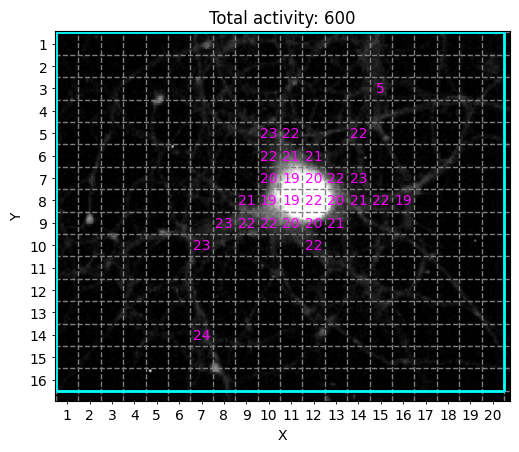

In [ ]:
# confirm that model can be executed with custom result directory:
results_directory = test_correct_model_run_with_custom_results_dir()

assert results_directory.exists()
# only one directory with analysis files should be created, as there are only one focus area:
assert len(list(results_directory.iterdir())) == 1

for directory in results_directory.iterdir():
    assert test_all_correct_files_created(directory)

# cleanup
rmtree(results_directory)

24-07-25 09:39:33.300615 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:39:33.300664 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:39:33.300678 (UTC): Starting with Job creation(s) for ../test_data/01
24-07-25 09:39:33.300712 (UTC): Looking for a valid recording file in ../test_data/01...
24-07-25 09:39:33.301026 (UTC): Found recording file of supported type at: ../test_data/01/Neuron_TTX-CNQX.avi.
24-07-25 09:39:33.301558 (UTC): Successfully created 1 out of 2 job(s) for ../test_data/01 at queue position: #1.
24-07-25 09:39:33.301605 (UTC): Successfully created 2 out of 2 job(s) for ../test_data/01 at queue position: #2.
24-07-25 09:39:33.301616 (UTC): Finished Job creation(s) for ../test_data/01!
24-07-25 09:39:33.301624 (UTC): All job creation(s) completed.
24-07-25 09:39:33.301634 (UTC): Configurations for Analysis Settings and Result Creation validated successfully.
24-

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:39:35.304715 (UTC): Results successfully created at: ../test_data/results/case_01/2025_07_24_11-39-33_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma
24-07-25 09:39:35.305354 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_01/2025_07_24_11-39-33_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma/logs.txt
24-07-25 09:39:35.307385 (UTC): Starting to process analysis job with index #1.
24-07-25 09:39:36.403511 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:39:37.242046 (UTC): Results successfully created at: ../test_data/results/case_01/2025_07_24_11-39-35_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites
24-07-25 09:39:37.242576 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_01/2025_07_24_11-39-35_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites/logs.txt


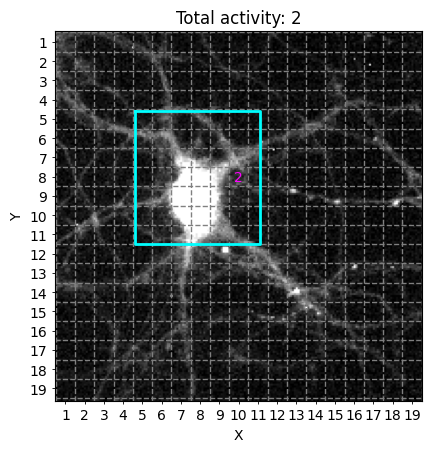

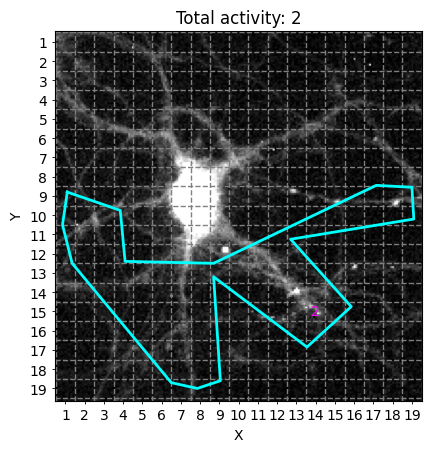

In [ ]:
# confirm that model can be executed with focus mode:
results_directory = test_run_grid_focus_mode()

assert results_directory.exists()

# only one directory should be created, as there are only one focus area:
assert len(list(results_directory.iterdir())) == 2
for directory in results_directory.iterdir():
    assert test_all_correct_files_created(directory, test_csv=False)

# cleanup
rmtree(results_directory)

24-07-25 09:39:37.527660 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:39:37.527745 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:39:37.528997 (UTC): Starting with Job creation(s) for ../test_data/00
24-07-25 09:39:37.529066 (UTC): Looking for a valid recording file in ../test_data/00...
24-07-25 09:39:37.529815 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
24-07-25 09:39:37.530002 (UTC): Successfully created a single job for ../test_data/00 at queue position: #1.
24-07-25 09:39:37.530024 (UTC): Finished Job creation(s) for ../test_data/00!
24-07-25 09:39:37.530042 (UTC): Starting with Job creation(s) for ../test_data/01
24-07-25 09:39:37.530060 (UTC): Looking for a valid recording file in ../test_data/01...
24-07-25 09:39:37.530236 (UTC): Found recording file of supported type at: ../test_data/01/Neuron_TTX-CNQX.avi.
24-07-25 09:39:3

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:39:41.669274 (UTC): Results successfully created at: ../test_data/results/case_02/00/2025_07_24_11-39-37_results_for_spiking_neuron
24-07-25 09:39:41.669712 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_02/00/2025_07_24_11-39-37_results_for_spiking_neuron/logs.txt
24-07-25 09:39:41.671641 (UTC): Starting to process analysis job with index #1.
24-07-25 09:39:51.821285 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:39:53.537234 (UTC): Results successfully created at: ../test_data/results/case_02/01/2025_07_24_11-39-41_results_for_Neuron_TTX-CNQX
24-07-25 09:39:53.537737 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_02/01/2025_07_24_11-39-41_results_for_Neuron_TTX-CNQX/logs.txt
24-07-25 09:39:53.545103 (UTC): Starting to process analysis job with index #2.
24-07-25 09:39:54.068260 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:39:57.255364 (UTC): Results successfully created at: ../test_data/results/case_02/02/2025_07_24_11-39-53_results_for_spiking_neuron
24-07-25 09:39:57.255810 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_02/02/2025_07_24_11-39-53_results_for_spiking_neuron/logs.txt


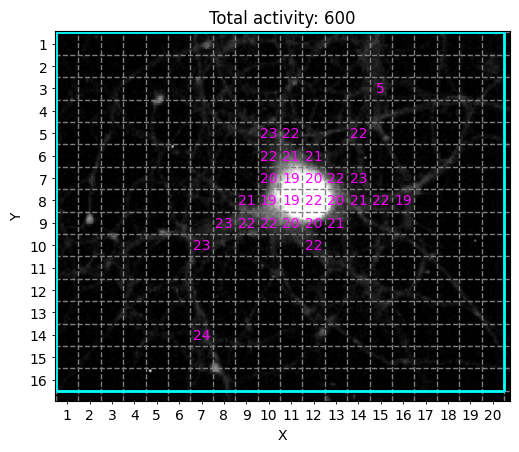

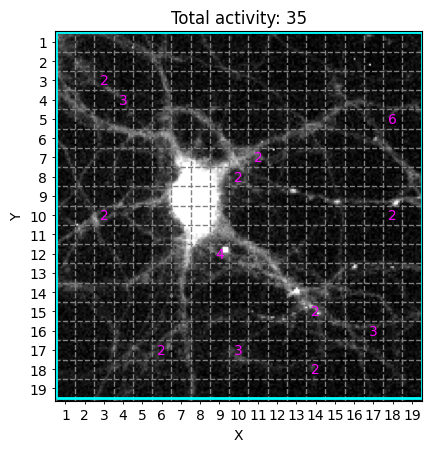

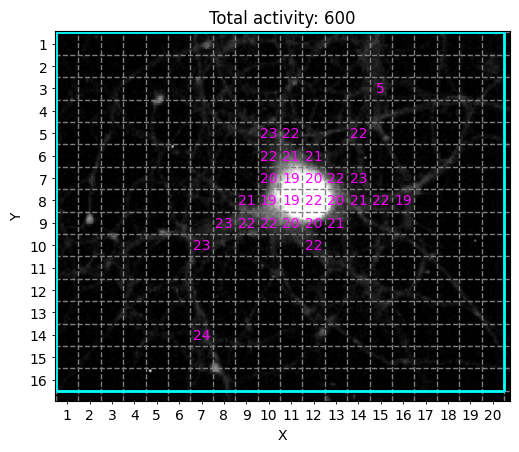

In [ ]:
# confirm that model can be executed with batch mode:
results_directory = test_run_grid_batch_mode()

assert results_directory.exists()

assert len(list(results_directory.iterdir())) == 3
for directory in results_directory.iterdir():
    for subdirectory in directory.iterdir():
        assert test_all_correct_files_created(subdirectory, test_csv=False)

# cleanup
rmtree(results_directory)

24-07-25 09:39:57.714530 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:39:57.714589 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:39:57.715665 (UTC): Starting with Job creation(s) for ../test_data/00
24-07-25 09:39:57.715708 (UTC): Looking for a valid recording file in ../test_data/00...
24-07-25 09:39:57.716397 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
24-07-25 09:39:57.717074 (UTC): Successfully created 1 out of 1 job(s) for ../test_data/00 at queue position: #1.
24-07-25 09:39:57.717102 (UTC): Finished Job creation(s) for ../test_data/00!
24-07-25 09:39:57.717119 (UTC): Starting with Job creation(s) for ../test_data/01
24-07-25 09:39:57.717446 (UTC): Looking for a valid recording file in ../test_data/01...
24-07-25 09:39:57.718190 (UTC): Found recording file of supported type at: ../test_data/01/Neuron_TTX-CNQX.avi.
24-07-25 09

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:01.268928 (UTC): Results successfully created at: ../test_data/results/case_03/00/2025_07_24_11-39-57_results_for_spiking_neuron_with_focus_spiking
24-07-25 09:40:01.269561 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/00/2025_07_24_11-39-57_results_for_spiking_neuron_with_focus_spiking/logs.txt
24-07-25 09:40:01.270838 (UTC): Starting to process analysis job with index #1.
24-07-25 09:40:02.426680 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:03.249511 (UTC): Results successfully created at: ../test_data/results/case_03/01/2025_07_24_11-40-01_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma
24-07-25 09:40:03.250219 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/01/2025_07_24_11-40-01_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma/logs.txt
24-07-25 09:40:03.251562 (UTC): Starting to process analysis job with index #2.
24-07-25 09:40:04.413692 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:05.281042 (UTC): Results successfully created at: ../test_data/results/case_03/01/2025_07_24_11-40-03_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites
24-07-25 09:40:05.281744 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/01/2025_07_24_11-40-03_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites/logs.txt
24-07-25 09:40:05.282458 (UTC): Starting to process analysis job with index #3.
24-07-25 09:40:06.635861 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:09.770233 (UTC): Results successfully created at: ../test_data/results/case_03/02/2025_07_24_11-40-05_results_for_spiking_neuron
24-07-25 09:40:09.774952 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/02/2025_07_24_11-40-05_results_for_spiking_neuron/logs.txt


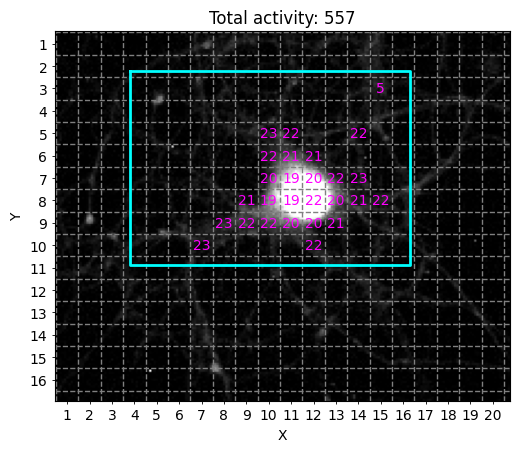

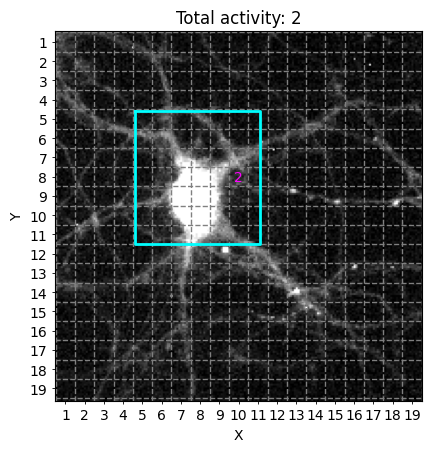

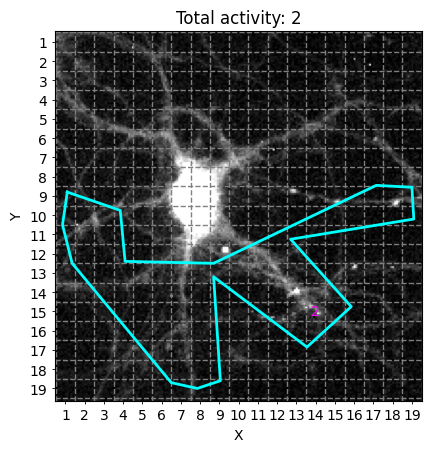

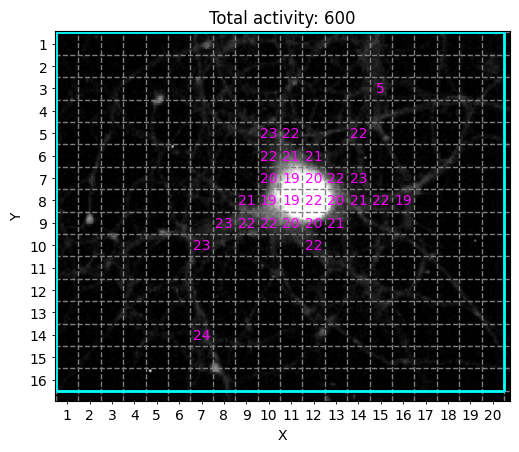

In [ ]:
# confirm that model can be executed with batch and focus mode:
results_directory = test_run_grid_focus_batch_mode()

assert results_directory.exists()

assert len(list(results_directory.iterdir())) == 3
for directory in results_directory.iterdir():
    # test case with multiple focus areas
    if '01' in directory.name:
        assert len(list(directory.iterdir())) == 2
    for subdirectory in directory.iterdir():
        assert test_all_correct_files_created(subdirectory, test_csv=False)

# cleanup
rmtree(results_directory)

24-07-25 09:40:10.344993 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:40:10.345054 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:40:10.345073 (UTC): Starting with Job creation(s) for ../test_data/01
24-07-25 09:40:10.345281 (UTC): Looking for a valid recording file in ../test_data/01...
24-07-25 09:40:10.345923 (UTC): Found recording file of supported type at: ../test_data/01/Neuron_TTX-CNQX.avi.
24-07-25 09:40:10.346985 (UTC): Successfully created 1 out of 2 job(s) for ../test_data/01 at queue position: #1.
24-07-25 09:40:10.347017 (UTC): Successfully created 2 out of 2 job(s) for ../test_data/01 at queue position: #2.
24-07-25 09:40:10.347026 (UTC): Finished Job creation(s) for ../test_data/01!
24-07-25 09:40:10.347035 (UTC): All job creation(s) completed.
24-07-25 09:40:10.347045 (UTC): Configurations for Analysis Settings and Result Creation validated successfully.
24-

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:11.607766 (UTC): Results successfully created at: ../test_data/results/case_01/2025_07_24_11-40-10_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma
24-07-25 09:40:11.608367 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_01/2025_07_24_11-40-10_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma/logs.txt
24-07-25 09:40:11.608615 (UTC): Starting to process analysis job with index #1.
24-07-25 09:40:12.247579 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:12.887006 (UTC): Results successfully created at: ../test_data/results/case_01/2025_07_24_11-40-11_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites
24-07-25 09:40:12.887618 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_01/2025_07_24_11-40-11_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites/logs.txt


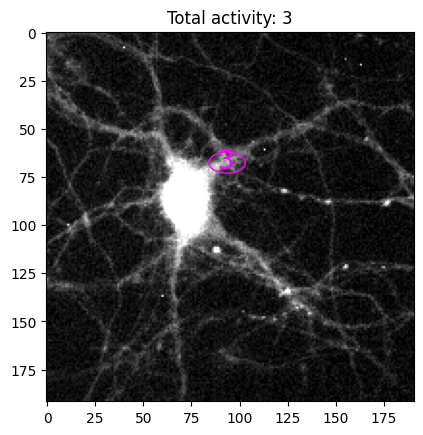

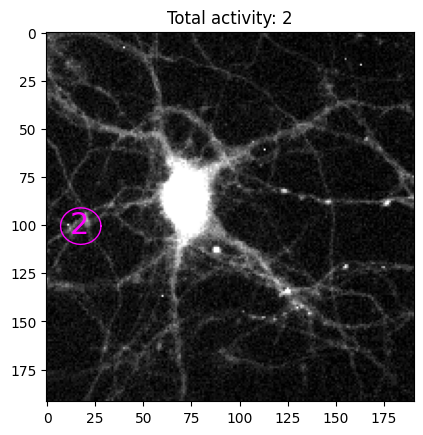

In [ ]:
# confirm that model can be executed with focus mode:
results_directory = test_run_file_focus_mode()

assert results_directory.exists()

# only one directory should be created, as there are only one focus area:
assert len(list(results_directory.iterdir())) == 2
for directory in results_directory.iterdir():
    assert test_all_correct_files_created(directory, test_csv=False)

# cleanup
rmtree(results_directory)

24-07-25 09:40:13.087494 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:40:13.087545 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:40:13.089378 (UTC): Starting with Job creation(s) for ../test_data/00
24-07-25 09:40:13.089445 (UTC): Looking for a valid recording file in ../test_data/00...
24-07-25 09:40:13.090106 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
24-07-25 09:40:13.090500 (UTC): Successfully created a single job for ../test_data/00 at queue position: #1.
24-07-25 09:40:13.090537 (UTC): Finished Job creation(s) for ../test_data/00!
24-07-25 09:40:13.090555 (UTC): Starting with Job creation(s) for ../test_data/01
24-07-25 09:40:13.090572 (UTC): Looking for a valid recording file in ../test_data/01...
24-07-25 09:40:13.090836 (UTC): Found recording file of supported type at: ../test_data/01/Neuron_TTX-CNQX.avi.
24-07-25 09:40:1

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:14.779999 (UTC): Results successfully created at: ../test_data/results/case_02/00/2025_07_24_11-40-13_results_for_spiking_neuron
24-07-25 09:40:14.780542 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_02/00/2025_07_24_11-40-13_results_for_spiking_neuron/logs.txt
24-07-25 09:40:14.780943 (UTC): Starting to process analysis job with index #1.
24-07-25 09:40:15.484638 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:16.250792 (UTC): Results successfully created at: ../test_data/results/case_02/01/2025_07_24_11-40-14_results_for_Neuron_TTX-CNQX
24-07-25 09:40:16.251323 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_02/01/2025_07_24_11-40-14_results_for_Neuron_TTX-CNQX/logs.txt
24-07-25 09:40:16.251774 (UTC): Starting to process analysis job with index #2.
24-07-25 09:40:16.585272 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:17.514340 (UTC): Results successfully created at: ../test_data/results/case_02/02/2025_07_24_11-40-16_results_for_spiking_neuron
24-07-25 09:40:17.515052 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_02/02/2025_07_24_11-40-16_results_for_spiking_neuron/logs.txt


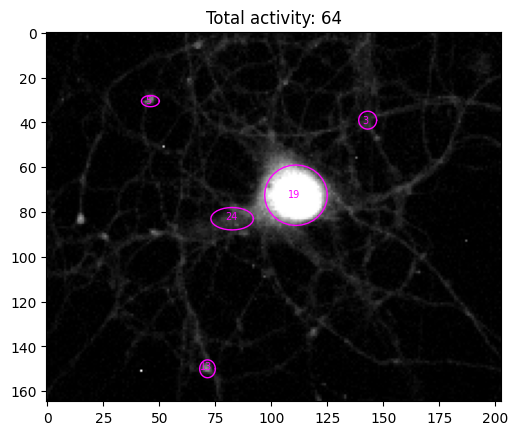

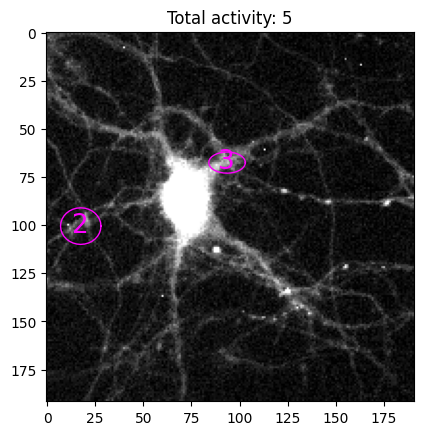

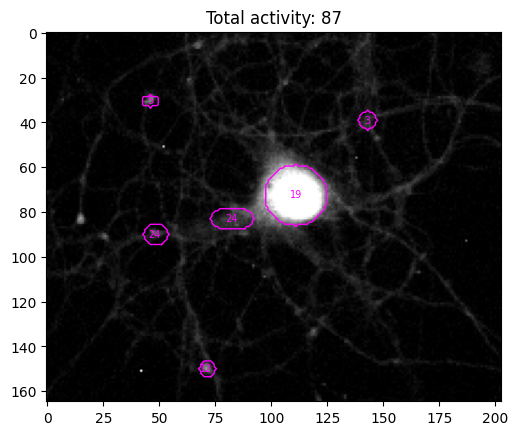

In [ ]:
# confirm that model can be executed with batch mode:
results_directory = test_run_file_batch_mode()

assert results_directory.exists()

assert len(list(results_directory.iterdir())) == 3
for directory in results_directory.iterdir():
    for subdirectory in directory.iterdir():
        assert test_all_correct_files_created(subdirectory, test_csv=False)

# cleanup
rmtree(results_directory)

24-07-25 09:40:17.817922 (UTC): Loading of new source data. All previously created jobs & logs will be deleted.
24-07-25 09:40:17.817976 (UTC): Basic configurations for data import validated. Starting creation of analysis job(s)...
24-07-25 09:40:17.819494 (UTC): Starting with Job creation(s) for ../test_data/00
24-07-25 09:40:17.819615 (UTC): Looking for a valid recording file in ../test_data/00...
24-07-25 09:40:17.820223 (UTC): Found recording file of supported type at: ../test_data/00/spiking_neuron.avi.
24-07-25 09:40:17.821427 (UTC): Successfully created 1 out of 1 job(s) for ../test_data/00 at queue position: #1.
24-07-25 09:40:17.821455 (UTC): Finished Job creation(s) for ../test_data/00!
24-07-25 09:40:17.821472 (UTC): Starting with Job creation(s) for ../test_data/01
24-07-25 09:40:17.821488 (UTC): Looking for a valid recording file in ../test_data/01...
24-07-25 09:40:17.821651 (UTC): Found recording file of supported type at: ../test_data/01/Neuron_TTX-CNQX.avi.
24-07-25 09

/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:19.155581 (UTC): Results successfully created at: ../test_data/results/case_03/00/2025_07_24_11-40-17_results_for_spiking_neuron_with_focus_spiking
24-07-25 09:40:19.156295 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/00/2025_07_24_11-40-17_results_for_spiking_neuron_with_focus_spiking/logs.txt
24-07-25 09:40:19.156860 (UTC): Starting to process analysis job with index #1.
24-07-25 09:40:19.799364 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:20.454829 (UTC): Results successfully created at: ../test_data/results/case_03/01/2025_07_24_11-40-19_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma
24-07-25 09:40:20.455536 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/01/2025_07_24_11-40-19_results_for_Neuron_TTX-CNQX_with_focus_ttx_soma/logs.txt
24-07-25 09:40:20.455900 (UTC): Starting to process analysis job with index #2.
24-07-25 09:40:21.557167 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:22.350946 (UTC): Results successfully created at: ../test_data/results/case_03/01/2025_07_24_11-40-20_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites
24-07-25 09:40:22.351498 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/01/2025_07_24_11-40-20_results_for_Neuron_TTX-CNQX_with_focus_ttx_neurites/logs.txt
24-07-25 09:40:22.352460 (UTC): Starting to process analysis job with index #3.
24-07-25 09:40:22.679591 (UTC): Analysis successfully completed. Continue with creation of results.. 


/Users/matveyloshakov/NeuralActivityCubic/.venv/lib/python3.11/site-packages/hdmf/container.py:521: UserWarning: The linked table for DynamicTableRegion 'rois' does not share an ancestor with the DynamicTableRegion.
  child._validate_on_set_parent()


24-07-25 09:40:23.664230 (UTC): Results successfully created at: ../test_data/results/case_03/02/2025_07_24_11-40-22_results_for_spiking_neuron
24-07-25 09:40:23.664959 (UTC): Updating all log files to contain all logs as final step. All valid logs files will end with this message.
Logs saved to ../test_data/results/case_03/02/2025_07_24_11-40-22_results_for_spiking_neuron/logs.txt


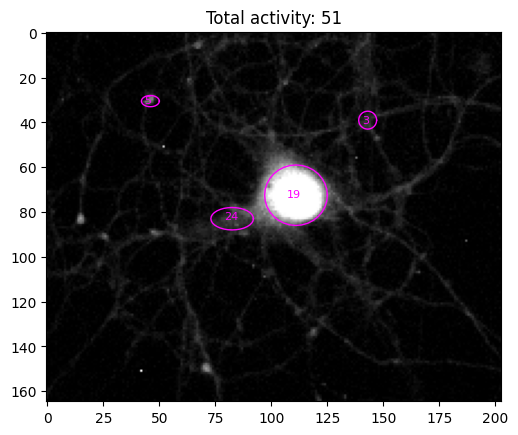

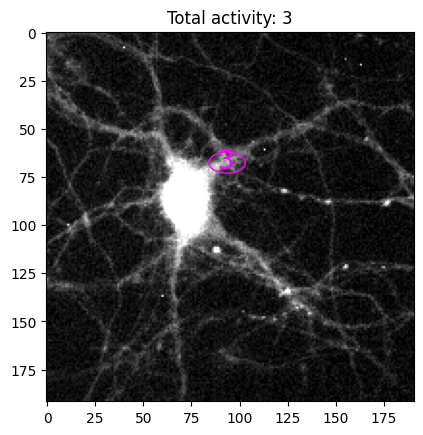

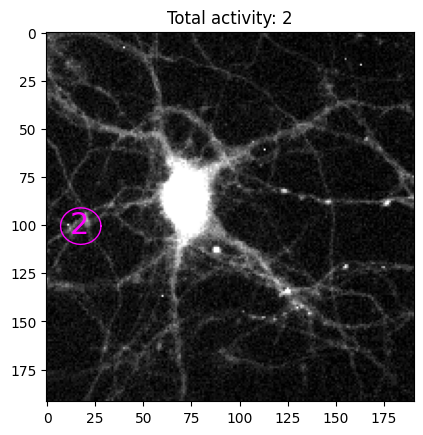

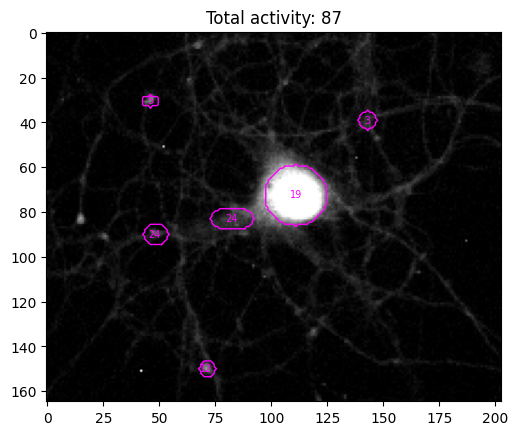

In [ ]:
# confirm that model can be executed with batch and focus mode:
results_directory = test_run_file_focus_batch_mode()

assert results_directory.exists()

assert len(list(results_directory.iterdir())) == 3
for directory in results_directory.iterdir():
    # test case with multiple focus areas
    if '01' in directory.name:
        assert len(list(directory.iterdir())) == 2
    for subdirectory in directory.iterdir():
        assert test_all_correct_files_created(subdirectory, test_csv=False)

# cleanup
rmtree(results_directory)